In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, WhiteKernel, ConstantKernel, Matern
from sklearn.model_selection import KFold

In [2]:
FAST_DEBUG = True
FONTSIZE = 14

In [3]:
vox_df = pd.read_csv('dataset/microstructure_stats.csv')
len(vox_df), vox_df.columns

(798,
 Index(['0', '1', '2', '3', '4', '5', '6', '7', '8', '9',
        ...
        '19673', '19674', '19675', '19676', '19677', '19678', '19679', '19680',
        '19681', '19682'],
       dtype='object', length=19683))

In [4]:
vox_std_scaler = StandardScaler()
vox_scaled = vox_std_scaler.fit_transform(vox_df)
vox_scaled.shape

(798, 19683)

In [5]:
if not FAST_DEBUG:
    n_list = []
    ev_list = []
    for n in tqdm(range(1, 50)):
        pca = PCA(n_components=n)
        pca.fit_transform(vox_scaled)
        n_list.append(n)
        ev_list.append(sum(pca.explained_variance_ratio_))

In [6]:
if not FAST_DEBUG:
    MAX_N = 30
    i = 7
    plt.figure(figsize=(8, 6))
    plt.plot(n_list[:MAX_N], ev_list[:MAX_N])
    plt.scatter(n_list[i], ev_list[i], c='r', marker='*', s=75, label=f'Elbow Point\n(n_components={n_list[i]})')
    plt.legend(fontsize=FONTSIZE-2)
    plt.title('PCA - Explained Variance vs Number of Components', fontsize=FONTSIZE)
    plt.xlabel('Number of Components', fontsize=FONTSIZE-2)
    plt.ylabel('Explained Variance', fontsize=FONTSIZE-2)

In [7]:
pca = PCA(n_components=8)
vox_pca = pca.fit_transform(vox_scaled)

In [8]:
train_df = pd.read_csv('dataset/training_data.csv')
test_df = pd.read_csv('dataset/testing_data.csv')
print(f"train: {len(train_df)}, test: {len(test_df)}")
print(f"train: {train_df.columns}\ntest: {test_df.columns}")

train: 1000, test: 250
train: Index(['microstructure ID', 'strength contrast', 'g', 'chi1', 'chi2'], dtype='object')
test: Index(['microstructure ID', 'strength contrast'], dtype='object')


In [9]:
vox_pca_train = vox_pca[train_df['microstructure ID'].values]
vox_pca_test = vox_pca[test_df['microstructure ID'].values]

In [10]:
sc_train = train_df[['strength contrast']]
sc_test = test_df[['strength contrast']]

In [11]:
X_train = np.concatenate([vox_pca_train, sc_train], axis=1)
X_test = np.concatenate([vox_pca_test, sc_test], axis=1)
X_train.shape, X_test.shape

((1000, 9), (250, 9))

In [12]:
X_scaler = StandardScaler()
X_train_scaled = X_scaler.fit_transform(X_train)
X_test_scaled = X_scaler.transform(X_test)

In [13]:
y_scaler = StandardScaler()
y_train = train_df[['g', 'chi1', 'chi2']]
y_train_scaled = y_scaler.fit_transform(y_train)

In [14]:
X_train_scaled.shape, y_train_scaled.shape

((1000, 9), (1000, 3))

In [15]:
kernel = 1 * RBF(length_scale=1.0, length_scale_bounds=(1e-2, 1e2))
gaussian_process = GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=9)
gaussian_process.fit(X_train_scaled, y_train_scaled)
gaussian_process.kernel_

0.991**2 * RBF(length_scale=0.202)

In [16]:
train_mean_pred_scaled, train_std_pred_scaled = gaussian_process.predict(
    X_train_scaled, return_std=True)

In [17]:
train_mean_pred = y_scaler.inverse_transform(train_mean_pred_scaled)
train_std_pred = y_scaler.inverse_transform(train_std_pred_scaled)
mse = np.mean((train_mean_pred - train_df[['g', 'chi1', 'chi2']].values)**2, axis=0)
mae = np.mean(np.abs(train_mean_pred - train_df[['g', 'chi1', 'chi2']].values), axis=0)
mse, mae

(array([2.44908664e-18, 7.11244404e-18, 3.83796935e-21]),
 array([2.67210066e-10, 3.70121875e-10, 2.63299629e-11]))

In [21]:
if FAST_DEBUG:
    K = 2
else:
    K = 5

def run_kernels(kernels):
    metrics = {}

    for kernel_str, kernel in kernels.items():
        print(f"Running kernel: {kernel_str}")

        mse_list = []
        mae_list = []

        kf = KFold(n_splits=K)
        for train_index, val_index in tqdm(kf.split(X_train_scaled), total=K):
            kf_X_train_scaled = X_train_scaled[train_index]
            kf_X_val_scaled = X_train_scaled[val_index]
            kf_y_train_scaled = y_train_scaled[train_index]
            kf_y_val_scaled = y_train_scaled[val_index]

            gaussian_process = GaussianProcessRegressor(kernel=kernel, alpha=1e-10, n_restarts_optimizer=0)
            gaussian_process.fit(kf_X_train_scaled, kf_y_train_scaled)

            val_mean_pred_scaled, val_std_pred_scaled = gaussian_process.predict(
                kf_X_val_scaled, return_std=True)
            
            val_mean_pred = y_scaler.inverse_transform(val_mean_pred_scaled)
            val_std_pred = y_scaler.inverse_transform(val_std_pred_scaled)

            kf_y_val_star = train_df[['g', 'chi1', 'chi2']].values[val_index]
            kf_y_val = y_scaler.inverse_transform(kf_y_val_scaled)
            # sanity check: kf_y_val_star == kf_y_val
            assert(np.allclose(kf_y_val_star, kf_y_val))
            mse = np.mean((val_mean_pred - kf_y_val)**2, axis=0)
            mae = np.mean(np.abs(val_mean_pred - kf_y_val), axis=0)
            mse_list.append(mse)
            mae_list.append(mae)
        mse_mean = np.mean(mse_list, axis=0)
        mse_std = np.std(mse_list, axis=0)
        mae_mean = np.mean(mae_list, axis=0)
        mae_std = np.std(mae_list, axis=0)
        metrics[kernel_str] = {
            'mse_mean': mse_mean,
            'mse_std': mse_std,
            'mae_mean': mae_mean,
            'mae_std': mae_std,
        }
    return metrics

In [29]:
def plot_kernel_performance(metrics, title=None, confidence_interval=False):
    # TODO - fix unit labels overlapping

    fig, ax1 = plt.subplots(figsize=(8, 6))

    ax1.set_xlabel('Kernel', fontsize=FONTSIZE-2)
    ax1.set_ylabel('g', fontsize=FONTSIZE-2)
    kernels = list(metrics.keys())
    g = np.array([metrics[k]['mse_mean'][0] for k in metrics.keys()])
    g_std = np.array([metrics[k]['mse_std'][0] for k in metrics.keys()])
    ax1.plot(kernels, g, label='g (MSE)', marker='o', color='r', linestyle='--')
    if confidence_interval:
        ax1.fill_between(kernels, g - g_std, g + g_std, alpha=0.2)
    ax1.tick_params(axis='y', labelcolor='r')
    ax1.set_ylabel('g', fontsize=FONTSIZE-2, color='r')
    ax1.legend(loc='upper left', fontsize=FONTSIZE-4)

    ax2 = ax1.twinx()
    chi1 = np.array([metrics[k]['mse_mean'][1] for k in metrics.keys()])
    chi1_std = np.array([metrics[k]['mse_std'][1] for k in metrics.keys()])
    ax2.plot(kernels, chi1, label='chi1 (MSE)', marker='o', color='g', linestyle='-.')
    if confidence_interval:
        ax2.fill_between(kernels, chi1 - chi1_std, chi1 + chi1_std, alpha=0.2)
    ax2.tick_params(axis='y', labelcolor='g')
    ax2.set_ylabel('chi1', fontsize=FONTSIZE-2, color='g')
    ax2.legend(loc='center right', fontsize=FONTSIZE-4)

    ax3 = ax1.twinx()
    chi2 = np.array([metrics[k]['mse_mean'][2] for k in metrics.keys()])
    chi2_std = np.array([metrics[k]['mse_std'][2] for k in metrics.keys()])
    ax3.plot(kernels, chi2, label='chi2 (MSE)', marker='o', color='b', linestyle=':')
    if confidence_interval:
        ax3.fill_between(kernels, chi2 - chi2_std, chi2 + chi2_std, alpha=0.2)
    ax3.tick_params(axis='y', labelcolor='b')
    ax3.set_ylabel('chi2', fontsize=FONTSIZE-2, color='b')
    ax3.legend(loc='lower right', fontsize=FONTSIZE-4)
    # move axis and unit label position up a bit
    ax3.spines['right'].set_position(('axes', 1.15))
    # ax3.get_yaxis().get_offset_text().set_visible(False)
    ax3.get_yaxis().get_offset_text().set_position((1.3, 0))

    if title is None:
        title = 'GPR - MSE vs Kernel'
    ax3.set_title(title, fontsize=FONTSIZE)

    fig.tight_layout()

In [35]:
def get_performance_table(metrics):
    data = {'Kernel': [], 'g (MSE)': [], 'chi1 (MSE)': [], 'chi2 (MSE)': []}
    for kernel, metric in metrics.items():
        data['Kernel'].append(kernel)
        for i, key in enumerate(['g', 'chi1', 'chi2']):
            data[f'{key} (MSE)'].append(f"{metric['mse_mean'][i]:.3f} ± {metric['mse_std'][i]:.3f}")
    return pd.DataFrame(data)

Running kernel: RBF_1e-2


100%|██████████| 2/2 [00:18<00:00,  9.35s/it]


Running kernel: RBF_1e-1


100%|██████████| 2/2 [00:15<00:00,  7.52s/it]


Running kernel: RBF_1e0


100%|██████████| 2/2 [00:22<00:00, 11.43s/it]


Running kernel: RBF_1e1


100%|██████████| 2/2 [00:25<00:00, 12.78s/it]


Running kernel: RBF_1e2


100%|██████████| 2/2 [00:18<00:00,  9.44s/it]


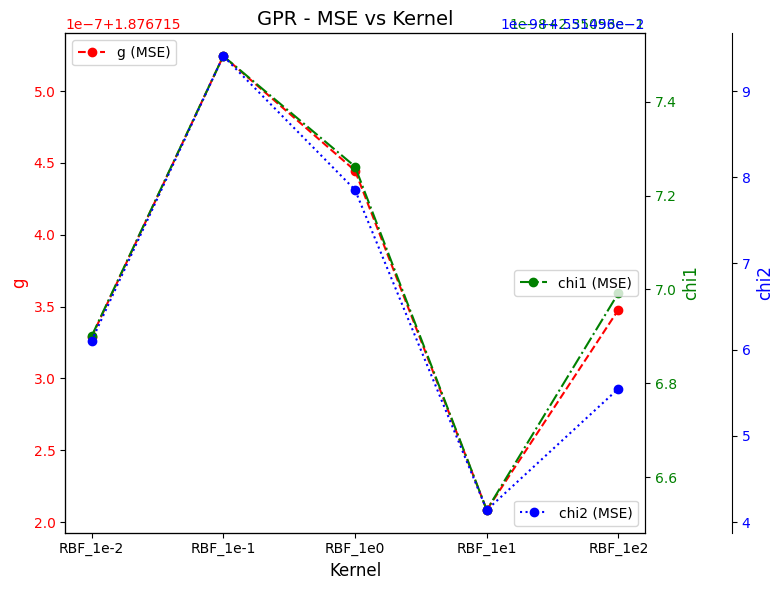

In [23]:
rbf_kernels = {
    'RBF_1e-2': 1 * RBF(length_scale=1e-2, length_scale_bounds=(1e-2, 1e2)),
    'RBF_1e-1': 1 * RBF(length_scale=1e-1, length_scale_bounds=(1e-2, 1e2)),
    'RBF_1e0': 1 * RBF(length_scale=1.0, length_scale_bounds=(1e-2, 1e2)),
    'RBF_1e1': 1 * RBF(length_scale=1e1, length_scale_bounds=(1e-2, 1e2)),
    'RBF_1e2': 1 * RBF(length_scale=1e2, length_scale_bounds=(1e-2, 1e2)),
}
rbf_metrics = run_kernels(rbf_kernels)
plot_kernel_performance(rbf_metrics, confidence_interval=False)
get_performance_table(rbf_metrics)

Running kernel: Matern_ls1e-2_nu0.1


  0%|          | 0/2 [00:00<?, ?it/s]/home/stevie/repos/microstructure_analysis/venv/lib/python3.8/site-packages/sklearn/gaussian_process/_gpr.py:663: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)
100%|██████████| 2/2 [01:40<00:00, 50.16s/it]


Running kernel: Matern_ls1e-2_nu0.5


  0%|          | 0/2 [00:00<?, ?it/s]/home/stevie/repos/microstructure_analysis/venv/lib/python3.8/site-packages/sklearn/gaussian_process/kernels.py:429: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__length_scale is close to the specified upper bound 100.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
100%|██████████| 2/2 [00:21<00:00, 10.94s/it]


Running kernel: Matern_ls1e-2_nu1


 50%|█████     | 1/2 [01:21<01:21, 81.18s/it]/home/stevie/repos/microstructure_analysis/venv/lib/python3.8/site-packages/sklearn/gaussian_process/_gpr.py:663: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)
100%|██████████| 2/2 [02:27<00:00, 73.82s/it]


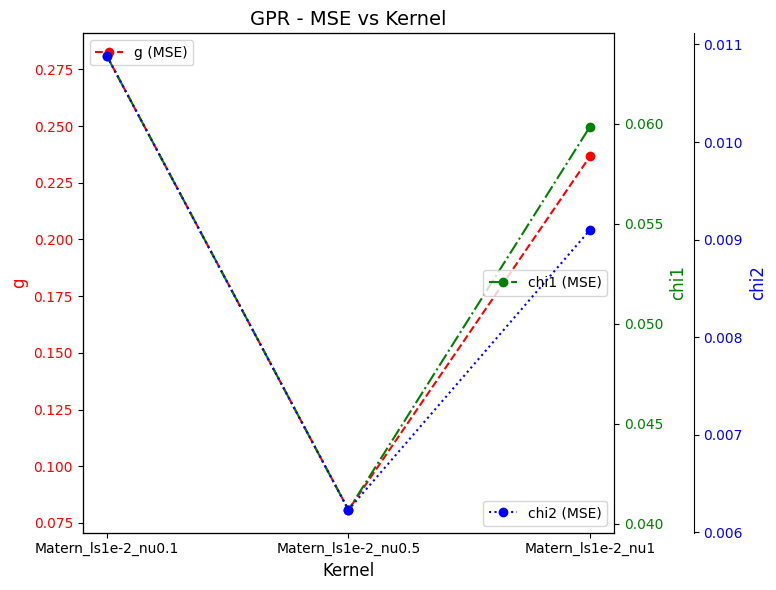

In [34]:
matern_kernels = {
    # winner is nu1
    'Matern_ls1e-2_nu0.1': 1 * Matern(length_scale=1e-2, length_scale_bounds=(1e-2, 1e2), nu=0.1),
    'Matern_ls1e-2_nu0.5': 1 * Matern(length_scale=1e-2, length_scale_bounds=(1e-2, 1e2), nu=0.5),
    'Matern_ls1e-2_nu1': 1 * Matern(length_scale=1e-2, length_scale_bounds=(1e-2, 1e2), nu=1),
    # 'Matern_ls1e-2_nu1.5': 1 * Matern(length_scale=1e-2, length_scale_bounds=(1e-2, 1e2), nu=1.5),
    # 'Matern_ls1e-2_nu2': 1 * Matern(length_scale=1e-2, length_scale_bounds=(1e-2, 1e2), nu=2),

    # no difference
    # 'Matern_1e-0_1e2': 1 * Matern(length_scale=1e-0, length_scale_bounds=(1e-2, 1e2)),
    # 'Matern_1e-0_1e3': 1 * Matern(length_scale=1e-0, length_scale_bounds=(1e-3, 1e3)),

    # 'Matern_1e-2': 1 * Matern(length_scale=1e-2, length_scale_bounds=(1e-2, 1e2)),
    # 'Matern_1e-1': 1 * Matern(length_scale=1e-1, length_scale_bounds=(1e-2, 1e2)),
    # 'Matern_1e0': 1 * Matern(length_scale=1.0, length_scale_bounds=(1e-2, 1e2)),
    # 'Matern_1e1': 1 * Matern(length_scale=1e1, length_scale_bounds=(1e-2, 1e2)),
    # 'Matern_1e2': 1 * Matern(length_scale=1e2, length_scale_bounds=(1e-2, 1e2)),
}
matern_metrics = run_kernels(matern_kernels)
plot_kernel_performance(matern_metrics, confidence_interval=False)
get_performance_table(matern_metrics)